In [15]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import glob  # Can be useful, but os.listdir is used here


In [16]:
print("TensorFlow Version:", tf.__version__)

SIZE = 256  # Image size (height and width)
BATCH_SIZE = 32  # Reduce batch size if memory issues occur with 500x500 images
CHANNELS = 1  # Grayscale images
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)
GENDER_FEATURE_SHAPE = (1,)  # Single feature for gender (0 or 1)
EPOCHS = 50  # Number of epochs to train (adjust as needed)
LEARNING_RATE = 4e-4  # Starting learning rate


TensorFlow Version: 2.19.0


In [17]:
base_dir = '.'

# Data Paths
train_csv_path = os.path.join(base_dir, 'Train', 'train_labels.csv')
val_csv_path = os.path.join(base_dir, 'Val', 'val_labels.csv')
test_csv_path = os.path.join(base_dir, 'Test', 'test_labels.csv')

train_image_dir = os.path.join(base_dir, 'Train', 'train_samples_pp')
val_image_dir = os.path.join(base_dir, 'Val', 'val_samples_pp')
test_image_dir = os.path.join(base_dir, 'Test', 'test_samples_pp')

checkpoint_filepath = 'best_bone_age_model.keras'  # Use .keras format


def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')

    df = df[['boneage', 'male']].rename(columns={'male': 'gender'})
    df['gender'] = df['gender'].astype(np.float32)
    df['boneage'] = df['boneage'].astype(np.float32)
    return df


def create_dataframe(image_dir, labels_df):
    data = []

    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            gender = labels_df.loc[file_id, 'gender']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage, 'gender': gender})

    return pd.DataFrame(data)


def preprocess_image(image, labels):
    """Preprocesses the image, passes labels through."""
    image = tf.image.resize(image, [SIZE, SIZE])
    # Ensure image has the correct channel dimension if decode_image didn't set it
    if image.shape[-1] is None:
        image = tf.reshape(image, [SIZE, SIZE, CHANNELS])
    elif image.shape[-1] != CHANNELS:
        # This might happen if images are color despite CHANNELS=1 setting
        # Force to grayscale if needed, or adjust CHANNELS config
        print(f"Warning: Image has {image.shape[-1]} channels, expected {CHANNELS}. Converting to grayscale.")
        image = tf.image.rgb_to_grayscale(image)  # Example if source is RGB

    image = tf.cast(image, tf.float32) / 255.0
    return image, labels  # labels = (boneage, gender)


def image_label_generator(file_paths, boneage_labels, gender_labels):
    """Yields images and a tuple of (boneage, gender) labels."""
    for path, boneage, gender in zip(file_paths, boneage_labels, gender_labels):
        try:
            img_bytes = tf.io.read_file(path)
            # Use decode_image and specify channels
            image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
            # Crucial: Set shape hint for resize, allow dynamic height/width initially
            image.set_shape([None, None, CHANNELS])
            yield image, (boneage, gender)  # Yield image and label tuple
        except tf.errors.InvalidArgumentError as e:
            print(f"Warning: Skipping file {path}. Error decoding image: {e}")
        except Exception as e:
            print(f"Warning: Skipping file {path}. Unexpected error: {e}")


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):

    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[
            dataframe['file_path'].values,
            dataframe['boneage'].values,
            dataframe['gender'].values],
        output_signature=(
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            (tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32))))

    # Apply image preprocessing
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Restructure the dataset elements for Keras multi-input model
    # Map (image, (boneage, gender)) to ((image, gender), boneage)
    dataset = dataset.map(lambda img, labels: ((img, labels[1]), labels[0]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# labels
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

# df
training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)


# repeat=True for train/validation
train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=True)
# repeat=False for final evaluation on test set
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)


In [18]:
def build_bone_age_model(input_shape, gender_shape):

    # inputs
    image_input = keras.Input(shape=input_shape, name="image_input")
    gender_input = keras.Input(shape=gender_shape, name="gender_input")

    # --- CNN Backbone ---
    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1a')(image_input)
    x = layers.BatchNormalization(name='bn1a')(x)
    x = layers.Activation('relu', name='relu1a')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1b')(x)
    x = layers.BatchNormalization(name='bn1b')(x)
    x = layers.Activation('relu', name='relu1b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)  # 500 -> 250

    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2a')(x)
    x = layers.BatchNormalization(name='bn2a')(x)
    x = layers.Activation('relu', name='relu2a')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2b')(x)
    x = layers.BatchNormalization(name='bn2b')(x)
    x = layers.Activation('relu', name='relu2b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)  # 250 -> 125

    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3a')(x)
    x = layers.BatchNormalization(name='bn3a')(x)
    x = layers.Activation('relu', name='relu3a')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3b')(x)
    x = layers.BatchNormalization(name='bn3b')(x)
    x = layers.Activation('relu', name='relu3b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool3')(x)  # 125 -> 62

    x = layers.Conv2D(256, (3, 3), padding='same', name='conv4a')(x)
    x = layers.BatchNormalization(name='bn4a')(x)
    x = layers.Activation('relu', name='relu4a')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', name='conv4b')(x)
    x = layers.BatchNormalization(name='bn4b')(x)
    x = layers.Activation('relu', name='relu4b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool4')(x)  # 62 -> 31

    x = layers.Conv2D(256, (3, 3), padding='same', name='conv5a')(x)
    x = layers.BatchNormalization(name='bn5a')(x)
    x = layers.Activation('relu', name='relu5a')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', name='conv5b')(x)
    x = layers.BatchNormalization(name='bn5b')(x)
    x = layers.Activation('relu', name='relu5b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool5')(x)  # 31 -> 15 (approx)

    # Feature Extraction
    image_features = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)  # (None, 256)

    # fusion with gender
    concatenated_features = layers.concatenate([image_features, gender_input],
                                               name='concatenate_features')  # (None, 257)

    # regression head
    x = layers.Dense(128, name='dense_head1')(concatenated_features)
    x = layers.BatchNormalization(name='bn_head1')(x)
    x = layers.Activation('relu', name='relu_head1')(x)
    x = layers.Dropout(0.4, name='dropout_head')(x)  # Regularization

    bone_age_output = layers.Dense(1, activation='linear', name='bone_age_output')(x)

    model = keras.Model(
        inputs=[image_input, gender_input],
        outputs=bone_age_output,
        name="bone_age_predictor")

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])  # months

    return model

model = build_bone_age_model(INPUT_SHAPE, GENDER_FEATURE_SHAPE)


In [19]:
model.summary()

Model: "bone_age_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1a (Conv2D)     │ (None, 256, 256,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1a                │ (None, 256, 256,  │        128 │ conv1a[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1a (Activation) │ (None, 256, 256,  │          0 │ bn1a[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1b (Conv2D)     │ (None, 256, 256,  │      9,248 │ relu1a[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1b                │ (None, 256, 256,  │        128 │ conv1b[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1b (Activation) │ (None, 256, 256,  │          0 │ bn1b[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 128, 128,  │          0 │ relu1b[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2a (Conv2D)     │ (None, 128, 128,  │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a                │ (None, 128, 128,  │        256 │ conv2a[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2a (Activation) │ (None, 128, 128,  │          0 │ bn2a[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2b (Conv2D)     │ (None, 128, 128,  │     36,928 │ relu2a[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2b                │ (None, 128, 128,  │        256 │ conv2b[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2b (Activation) │ (None, 128, 128,  │          0 │ bn2b[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 64, 64,    │          0 │ relu2b[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3a (Conv2D)     │ (None, 64, 64,    │     73,856 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3a                │ (None, 64, 64,    │        512 │ conv3a[0][0]    

 Total params: 2,391,393 (9.12 MB)

 Trainable params: 2,388,193 (9.11 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [20]:
# Callback to save the best model based on validation MAE
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the full model
    monitor='val_mae',  # Monitor validation Mean Absolute Error
    mode='min',  # Mode should be 'min' for MAE/loss
    save_best_only=True,  # Only save when performance improves
    verbose=1)

# Callback for early stopping if validation MAE doesn't improve
early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min',
    restore_best_weights=True)  # Restore model weights from the epoch with the best value

# Callback to reduce learning rate when validation MAE plateaus
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,
    mode='min',
    min_lr=1e-6)  # Lower bound on the learning rate

callback_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [21]:
print("\n--- Starting Training ---")

# Calculate steps per epoch
# Ensure dataframes were loaded correctly before this step
if 'training_dataframe' in locals() and not training_dataframe.empty and \
        'validation_dataframe' in locals() and not validation_dataframe.empty:

    steps_per_epoch = len(training_dataframe) // BATCH_SIZE
    validation_steps = len(validation_dataframe) // BATCH_SIZE

    if steps_per_epoch == 0 or validation_steps == 0:
        print("Warning: steps_per_epoch or validation_steps is zero. ")
        print("Check BATCH_SIZE and the number of samples in training/validation sets.")
        # Decide how to proceed: maybe exit, or maybe run with steps=1?
        # Setting steps=1 if 0 might hide issues but allows running.
        steps_per_epoch = max(1, steps_per_epoch)
        validation_steps = max(1, validation_steps)

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        callbacks=callback_list,
        verbose=1  # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
    )

    print("Training finished.")
    print("-" * 25)

else:
    print("ERROR: Training cannot start because dataframes were not loaded properly.")
    history = None  # Ensure history object exists but is None




--- Starting Training ---
Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 16716.3594 - mae: 122.8147
Epoch 1: val_mae improved from inf to 116.18781, saving model to best_bone_age_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 996s 3s/step - loss: 16714.6426 - mae: 122.8083 - val_loss: 15245.8525 - val_mae: 116.1878 - learning_rate: 4.0000e-04
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13518.7910 - mae: 110.1213
Epoch 2: val_mae did not improve from 116.18781
376/376 ━━━━━━━━━━━━━━━━━━━━ 965s 3s/step - loss: 13515.9385 - mae: 110.1090 - val_loss: 17055.2090 - val_mae: 123.6988 - learning_rate: 4.0000e-04
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8880.2930 - mae: 88.5963
Epoch 3: val_mae improved from 116.18781 to 42.49887, saving model to best_bone_age_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 964s 3s/step - loss: 8877.2109 - mae: 88.5793 - val_loss: 2385.6260 - val_mae: 42.4989 - learning_rate: 4.0000e-04
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s

In [33]:
best_model = keras.models.load_model(checkpoint_filepath)

test_results = best_model.evaluate(test_dataset_eval, verbose=1,steps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 88.5191 - mae: 7.8244


In [39]:
test_results

[88.51911926269531, 7.824416160583496]

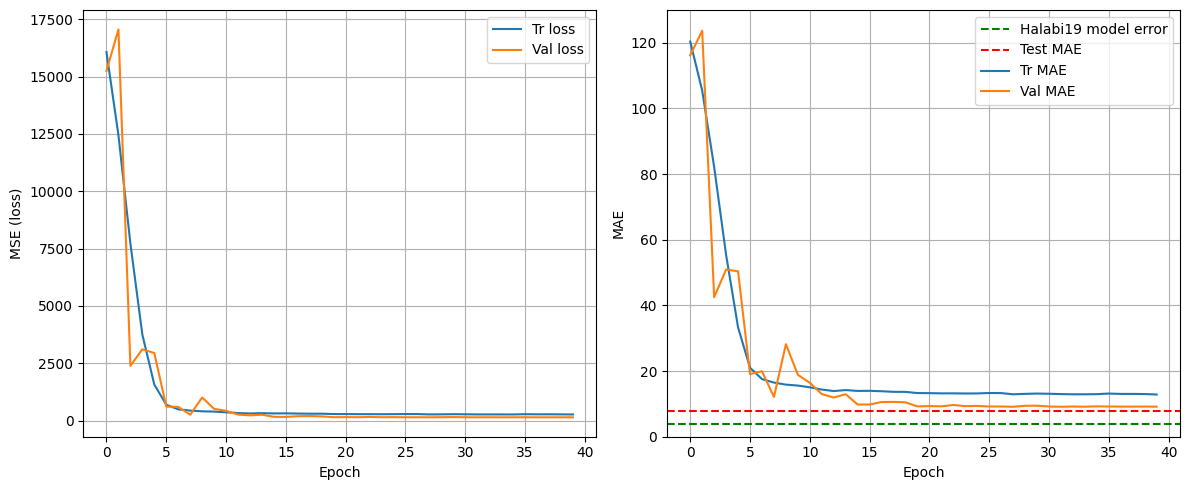

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Tr loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.ylim(0, 130)
plt.axhline(y=4, color='g', linestyle='--', label='Halabi19 model error')
plt.axhline(y=test_results[1], color='r', linestyle='--', label='Test MAE')
plt.plot(history.history['mae'], label='Tr MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
